In [77]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from effdet import get_efficientdet_config, EfficientDet
from effdet.bench import DetBenchTrain
import numpy as np
import cv2
import os
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [78]:
# 🔹 Custom Flickr8K Dataset
class Flickr8KDataset(Dataset):
    def __init__(self, image_folder, label_folder):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_files = os.listdir(image_folder)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((512, 512))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        label_path = os.path.join(self.label_folder, self.image_files[idx].replace('.jpg', '.txt'))
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        img = self.transform(img)
        
        boxes, labels = [], []
        try:
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # Skip malformed lines
                    class_id, x_center, y_center, width, height = map(float, parts)
                    x1 = (x_center - width / 2) * w
                    y1 = (y_center - height / 2) * h
                    x2 = (x_center + width / 2) * w
                    y2 = (y_center + height / 2) * h
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(class_id))
        except FileNotFoundError:
            pass
        
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx], dtype=torch.int64)  # ✅ Add image_id
        }
        
        return img, target


In [79]:
# 🔹 Load Dataset
data_path = "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.yolov8"
train_dataset = Flickr8KDataset(f"{data_path}/train/images", f"{data_path}/train/labels")
valid_dataset = Flickr8KDataset(f"{data_path}/valid/images", f"{data_path}/valid/labels")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [80]:
from effdet.bench import DetBenchPredict
from effdet import create_model

# 🔹 Load EfficientDet Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = get_efficientdet_config("tf_efficientdet_d0")
model = EfficientDet(config, pretrained_backbone=True)


model = DetBenchTrain(model, config).to(device)  # Training mode

model_eval = create_model("tf_efficientdet_d0", pretrained=True, bench_task="predict").to(device)
model_eval.eval()  # Set to eval mode


optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)


In [82]:
# 🔹 Training Loop
for epoch in range(100):
    model.train()
    epoch_loss = 0
    
    for images, targets in train_loader:
        images = torch.stack([img.to(device) for img in images])
        targets = {
            'bbox': [t['boxes'].to(device) for t in targets],
            'cls': [t['labels'].to(device) for t in targets]
        }


        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}")

print("✅ EfficientDet Training Completed")

Epoch 1: Loss = 22.8245
Epoch 2: Loss = 10.9717
Epoch 3: Loss = 10.3744
Epoch 4: Loss = 8.9310
Epoch 5: Loss = 8.6935
Epoch 6: Loss = 7.8897
Epoch 7: Loss = 7.5276
Epoch 8: Loss = 7.2433
Epoch 9: Loss = 7.2151
Epoch 10: Loss = 6.8616
Epoch 11: Loss = 6.6707
Epoch 12: Loss = 6.4115
Epoch 13: Loss = 6.2917
Epoch 14: Loss = 6.3925
Epoch 15: Loss = 6.0212
Epoch 16: Loss = 6.0962
Epoch 17: Loss = 5.8550
Epoch 18: Loss = 5.6969
Epoch 19: Loss = 5.5210
Epoch 20: Loss = 5.6155
Epoch 21: Loss = 5.5847
Epoch 22: Loss = 5.3526
Epoch 23: Loss = 5.4262
Epoch 24: Loss = 5.1813
Epoch 25: Loss = 5.2447
Epoch 26: Loss = 5.1184
Epoch 27: Loss = 5.1323
Epoch 28: Loss = 5.0257
Epoch 29: Loss = 4.9965
Epoch 30: Loss = 4.8375
Epoch 31: Loss = 4.8210
Epoch 32: Loss = 4.6858
Epoch 33: Loss = 4.5701
Epoch 34: Loss = 4.5519
Epoch 35: Loss = 4.5772
Epoch 36: Loss = 4.4465
Epoch 37: Loss = 4.4303
Epoch 38: Loss = 4.3646
Epoch 39: Loss = 4.2968
Epoch 40: Loss = 4.3035
Epoch 41: Loss = 4.2972
Epoch 42: Loss = 4.272

In [93]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 🔹 Generate Predictions
def generate_predictions(model, data_loader, device):
    model.eval()  # Set to evaluation mode
    predictions = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])

            # Get model predictions (now we know it's a tensor)
            outputs = model(images)  # Shape: (batch_size, num_predictions, 6)

            # Debugging print statement
            print(f"Model Output Shape: {outputs.shape}")  # Expected: [B, N, 6]
            
            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()  # Ensure image_id is correctly retrieved
                
                output = output.cpu().numpy()  # Move to CPU
                
                for pred in output:
                    x_min, y_min, x_max, y_max, score, label = pred  # Extract values
                    if score < 0.05:  # Ignore very low-confidence predictions
                        continue
                    
                    predictions.append({
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],  # COCO format
                        "score": float(score)
                    })

    return predictions



# Run the function to generate predictions
predictions = generate_predictions(model_eval, valid_loader, device)

# 🔹 Save Predictions as JSON
with open("predictions.json", "w") as f:
    json.dump(predictions, f)

print("✅ Predictions saved as predictions.json")


Model Output Shape: torch.Size([4, 100, 6])
Model Output Shape: torch.Size([4, 100, 6])
Model Output Shape: torch.Size([4, 100, 6])
Model Output Shape: torch.Size([3, 100, 6])
✅ Predictions saved as predictions.json


In [94]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 🔹 Load Ground Truth Annotations
coco_gt = COCO("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json")  # Update path to the ground truth COCO JSON

# 🔹 Load Predictions
coco_dt = coco_gt.loadRes("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\predictions.json")

# 🔹 Initialize COCO Evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [95]:
import json
with open("predictions.json", "r") as f:
    predictions = json.load(f)
print(predictions[:5])  # Show first 5 predictions


[{'image_id': 0, 'category_id': 1, 'bbox': [82.99806213378906, 117.86614227294922, 259.65399169921875, 221.0150146484375], 'score': 0.8128237724304199}, {'image_id': 0, 'category_id': 1, 'bbox': [79.77079772949219, 132.42144775390625, 183.98292541503906, 157.01910400390625], 'score': 0.17723140120506287}, {'image_id': 0, 'category_id': 36, 'bbox': [82.84495544433594, 115.20504760742188, 258.24359130859375, 225.01461791992188], 'score': 0.10980084538459778}, {'image_id': 0, 'category_id': 1, 'bbox': [74.68646240234375, 104.20184326171875, 375.74481201171875, 361.149169921875], 'score': 0.10897643864154816}, {'image_id': 0, 'category_id': 35, 'bbox': [85.00730895996094, 121.90159606933594, 249.07167053222656, 207.0725860595703], 'score': 0.10428427904844284}]


In [96]:
gt_annotations = coco_gt.dataset["annotations"][:5]
print(gt_annotations)


[{'id': 0, 'image_id': 0, 'category_id': 24, 'bbox': [53, 25, 311, 614.5], 'area': 191109.5, 'segmentation': [], 'iscrowd': 0, 'ignore': 0, '_ignore': 0}, {'id': 1, 'image_id': 0, 'category_id': 18, 'bbox': [291, 184, 231.5, 455.5], 'area': 105448.25, 'segmentation': [], 'iscrowd': 0, 'ignore': 0, '_ignore': 0}, {'id': 2, 'image_id': 0, 'category_id': 24, 'bbox': [0, 282, 24, 355], 'area': 8520, 'segmentation': [], 'iscrowd': 0, 'ignore': 0, '_ignore': 1}, {'id': 3, 'image_id': 1, 'category_id': 24, 'bbox': [25, 23, 539, 607.5], 'area': 327442.5, 'segmentation': [], 'iscrowd': 0, 'ignore': 0, '_ignore': 0}, {'id': 4, 'image_id': 2, 'category_id': 24, 'bbox': [364, 46, 188, 584.5], 'area': 109886, 'segmentation': [], 'iscrowd': 0, 'ignore': 0, '_ignore': 0}]


In [97]:
gt_category_ids = {cat['id']: cat['name'] for cat in coco_gt.dataset['categories']}
print("Ground Truth Categories:", gt_category_ids)


Ground Truth Categories: {0: 'objects', 1: 'Carton', 2: 'Hat', 3: 'Mountains', 4: 'Pipe', 5: 'Polythene', 6: 'Tent', 7: 'Tub', 8: 'backpack', 9: 'baseball glove', 10: 'bed', 11: 'bicycle', 12: 'bird', 13: 'boat', 14: 'car', 15: 'cat', 16: 'cell phone', 17: 'couch', 18: 'dog', 19: 'frisbee', 20: 'handbag', 21: 'horse', 22: 'motorcycle', 23: 'mug', 24: 'person', 25: 'potted plant', 26: 'rope', 27: 'skateboard', 28: 'sports ball', 29: 'suitcase', 30: 'surfboard', 31: 'table', 32: 'tree', 33: 'umbrella'}


In [100]:
import json

# Load predictions and ground truth categories
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\predictions.json", "r") as f:
    predictions = json.load(f)

with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json", "r") as f:
    coco_gt = json.load(f)

# Extract category mapping from ground truth
category_mapping = {cat["id"]: cat["name"] for cat in coco_gt["categories"]}
inverse_category_mapping = {v: k for k, v in category_mapping.items()}

# Fix category IDs in predictions
for pred in predictions:
    old_category_id = pred["category_id"]
    category_name = category_mapping.get(old_category_id, None)
    
    if category_name and category_name in inverse_category_mapping:
        pred["category_id"] = inverse_category_mapping[category_name]
    else:
        print(f"⚠️ Warning: Category ID {old_category_id} not found in ground truth!")

# Save fixed predictions
with open("fixed_predictions.json", "w") as f:
    json.dump(predictions, f, indent=4)

print("✅ Fixed predictions saved as fixed_predictions.json")


⚠️ Warning: Category ID 36 not found in ground truth!
⚠️ Warning: Category ID 35 not found in ground truth!
⚠️ Warning: Category ID 42 not found in ground truth!
⚠️ Warning: Category ID 42 not found in ground truth!
⚠️ Warning: Category ID 36 not found in ground truth!
⚠️ Warning: Category ID 34 not found in ground truth!
⚠️ Warning: Category ID 77 not found in ground truth!
⚠️ Warning: Category ID 77 not found in ground truth!
⚠️ Warning: Category ID 77 not found in ground truth!
⚠️ Warning: Category ID 64 not found in ground truth!
⚠️ Warning: Category ID 64 not found in ground truth!
⚠️ Warning: Category ID 34 not found in ground truth!
⚠️ Warning: Category ID 34 not found in ground truth!
⚠️ Warning: Category ID 34 not found in ground truth!
⚠️ Warning: Category ID 64 not found in ground truth!
⚠️ Warning: Category ID 39 not found in ground truth!
⚠️ Warning: Category ID 62 not found in ground truth!
⚠️ Warning: Category ID 86 not found in ground truth!
⚠️ Warning: Category ID 43 n

In [103]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 🔹 Load Ground Truth Annotations as a COCO object
coco_gt = COCO("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json")

# 🔹 Load Fixed Predictions
coco_dt = coco_gt.loadRes("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\fixed_predictions.json")

# 🔹 Initialize COCO Evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [106]:
import json

# Load ground truth annotations
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json", "r") as f:
    coco_gt = json.load(f)

# Load predictions
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\fixed_predictions.json", "r") as f:
    predictions = json.load(f)

# Get valid image IDs from ground truth
valid_image_ids = {img["id"] for img in coco_gt["images"]}

# Process predictions
filtered_predictions = []
for pred in predictions:
    # Ensure image_id exists in ground truth
    if pred["image_id"] not in valid_image_ids:
        continue  

    # Convert bounding box format if needed (ensure it's [x, y, width, height])
    x_min, y_min, width, height = pred["bbox"]  
    pred["bbox"] = [x_min, y_min, width, height]  

    # Filter out low-score predictions
    if pred["score"] >= 0.5:
        filtered_predictions.append(pred)

# Save fixed predictions
with open("fixed_predictions_v2.json", "w") as f:
    json.dump(filtered_predictions, f, indent=4)

print("✅ Fixed predictions saved as fixed_predictions_v2.json")


✅ Fixed predictions saved as fixed_predictions_v2.json


In [107]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 🔹 Load Ground Truth Annotations as a COCO object
coco_gt = COCO("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json")

# 🔹 Load Fixed Predictions
coco_dt = coco_gt.loadRes("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\fixed_predictions_v2.json")

# 🔹 Initialize COCO Evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [108]:
import json

# Load ground truth
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json", "r") as f:
    coco_gt = json.load(f)

# Load predictions
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\fixed_predictions_v2.json", "r") as f:
    predictions = json.load(f)

# Get valid image IDs from ground truth
valid_image_ids = {img["id"] for img in coco_gt["images"]}

# Get unique image IDs in predictions
pred_image_ids = {pred["image_id"] for pred in predictions}

# Find mismatched image IDs
missing_image_ids = pred_image_ids - valid_image_ids

print("Valid Image IDs in Ground Truth:", valid_image_ids)
print("Image IDs in Predictions:", pred_image_ids)
print("Mismatched Image IDs:", missing_image_ids)


Valid Image IDs in Ground Truth: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78}
Image IDs in Predictions: {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Mismatched Image IDs: set()


In [109]:
# Get ground truth category IDs
gt_category_ids = {cat["id"]: cat["name"] for cat in coco_gt["categories"]}
pred_category_ids = {pred["category_id"] for pred in predictions}

# Find category mismatches
invalid_categories = pred_category_ids - set(gt_category_ids.keys())

print("Ground Truth Categories:", gt_category_ids)
print("Predicted Categories:", pred_category_ids)
print("Invalid Categories in Predictions:", invalid_categories)


Ground Truth Categories: {0: 'objects', 1: 'Carton', 2: 'Hat', 3: 'Mountains', 4: 'Pipe', 5: 'Polythene', 6: 'Tent', 7: 'Tub', 8: 'backpack', 9: 'baseball glove', 10: 'bed', 11: 'bicycle', 12: 'bird', 13: 'boat', 14: 'car', 15: 'cat', 16: 'cell phone', 17: 'couch', 18: 'dog', 19: 'frisbee', 20: 'handbag', 21: 'horse', 22: 'motorcycle', 23: 'mug', 24: 'person', 25: 'potted plant', 26: 'rope', 27: 'skateboard', 28: 'sports ball', 29: 'suitcase', 30: 'surfboard', 31: 'table', 32: 'tree', 33: 'umbrella'}
Predicted Categories: {64, 1, 16, 18, 19}
Invalid Categories in Predictions: {64}


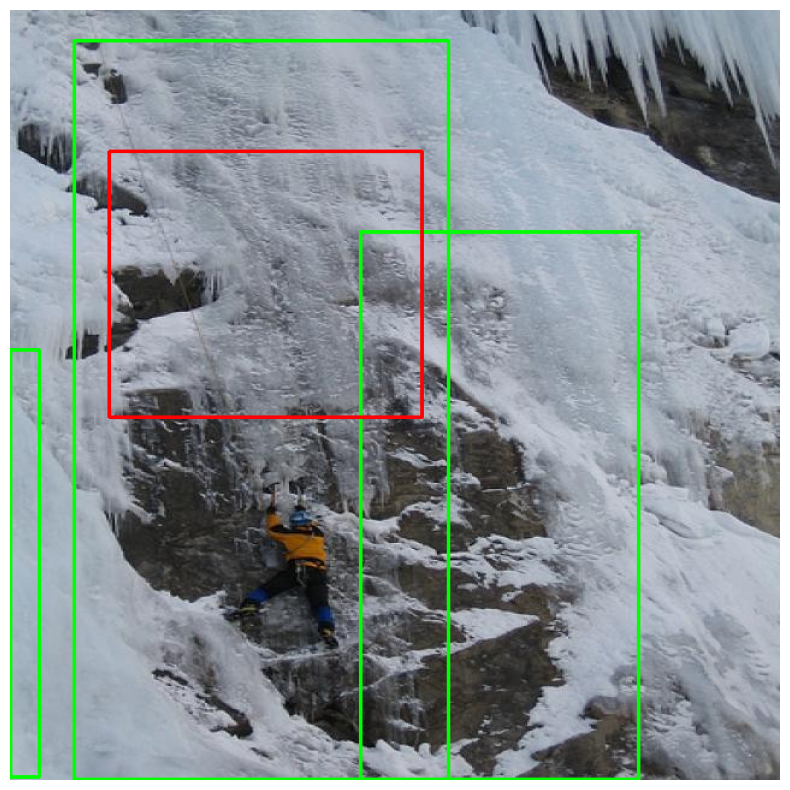

In [110]:
import cv2
import matplotlib.pyplot as plt

# Load an image from the dataset
image_path = "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\97577988_65e2eae14a_jpg.rf.20cab244e9f16ce78a09312a6be00474.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load annotations
annotations = [ann for ann in coco_gt["annotations"] if ann["image_id"] == 0]  # Replace with actual image_id
preds = [pred for pred in predictions if pred["image_id"] == 0]  # Replace with actual image_id

# Draw Ground Truth Bounding Boxes
for ann in annotations:
    x, y, w, h = ann["bbox"]
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)  # Green = Ground Truth

# Draw Predicted Bounding Boxes
for pred in preds:
    x, y, w, h = pred["bbox"]
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)  # Blue = Prediction

# Show Image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.show()


In [111]:
filtered_predictions = [pred for pred in predictions if pred["category_id"] in category_mapping]

# Save filtered predictions
with open("fixed_predictions_v4.json", "w") as f:
    json.dump(filtered_predictions, f, indent=4)

print("✅ Removed invalid category IDs. Saved as fixed_predictions_v4.json")


✅ Removed invalid category IDs. Saved as fixed_predictions_v4.json


In [112]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json")
coco_dt = coco_gt.loadRes("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\fixed_predictions_v4.json")

coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [113]:
num_classes = 34  # Your dataset has 34 classes (including background)


flickr8k_classes = {
    0: "objects", 1: "Carton", 2: "Hat", 3: "Mountains", 4: "Pipe", 5: "Polythene", 6: "Tent", 
    7: "Tub", 8: "Backpack", 9: "Baseball Glove", 10: "Bed", 11: "Bicycle", 12: "Bird", 13: "Boat", 
    14: "Car", 15: "Cat", 16: "Cell Phone", 17: "Couch", 18: "Dog", 19: "Frisbee", 20: "Handbag", 
    21: "Horse", 22: "Motorcycle", 23: "Mug", 24: "Person", 25: "Potted Plant", 26: "Rope", 
    27: "Skateboard", 28: "Sports Ball", 29: "Suitcase", 30: "Surfboard", 31: "Table", 32: "Tree", 
    33: "Umbrella"
}



In [114]:
from torchvision.ops import box_iou

def run_inference(model, dataloader, device):
    model.eval()
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = torch.stack([img.to(device) for img in images])
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                if isinstance(pred, torch.Tensor):
                    pred = pred.cpu().numpy()  # Convert to NumPy

                if len(pred.shape) == 1 or pred.shape[0] == 0:
                    pred_boxes = np.array([]).reshape(0, 4)
                    pred_scores = np.array([])
                    pred_labels = np.array([])
                else:
                    pred_boxes = pred[:, :4]  # Extract bounding boxes
                    pred_scores = pred[:, 4]  # Extract confidence scores
                    pred_labels = pred[:, 5].astype(int) if pred.shape[1] > 5 else np.ones(len(pred_boxes), dtype=int)  # Extract class labels (force integer type)

                # Ground truth
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()

                # Ensure class labels are within valid range
                pred_labels = np.clip(pred_labels, 0, 32)  # Adjust based on class indexing

                # Append predictions and ground truths
                all_preds.append((pred_boxes, pred_scores, pred_labels))
                all_gts.append((gt_boxes, gt_labels))

    return all_preds, all_gts

# Run inference
all_preds, all_gts = run_inference(model_eval, valid_loader, device)


In [115]:
print("Sample Prediction Output:", all_preds[:2])
print("Sample Ground Truth Output:", all_gts[:2])


Sample Prediction Output: [(array([[ 82.99806 , 117.86614 , 342.65204 , 338.88116 ],
       [ 79.7708  , 132.42145 , 263.75372 , 289.44055 ],
       [ 82.844955, 115.20505 , 341.08856 , 340.21967 ],
       [ 74.68646 , 104.20184 , 450.43127 , 465.351   ],
       [ 85.00731 , 121.901596, 334.07898 , 328.97418 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 81.79416 , 193.0727  , 197.62958 , 281.898   ],
       [ 82.464386, 173.47812 , 201.03616 , 281.05414 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 82.98089 , 147.06876 , 206.28467 , 291.22537 ],
       [ 82.98089 , 147.06876 , 206.28467 , 291.22537 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 79.7708  , 132.42145 , 263.75372 , 289.44055 ],
       [ 81.40428 , 204.67233 , 175.75783 , 282.33212 ],
       [121.47196 ,  43.082146, 300.1394  , 285.9113  ],
       [ 91.70517 , 118.02341 , 339.089   , 336.1818  ],
       [ 49.40921 ,  39.296524, 485.30777 , 327.45142 ],
   

In [116]:
def compute_map(all_preds, all_gts, iou_thresholds=[0.5, 0.75]):
    aps = []
    
    for iou_threshold in iou_thresholds:
        precisions = []
        recalls = []
        
        for (pred_boxes, pred_scores, pred_labels), (gt_boxes, gt_labels) in zip(all_preds, all_gts):
            if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                continue
            
            # Compute IoU between predictions and ground truth
            ious = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes)).numpy()
            
            true_positives = []
            false_positives = []
            
            for i, pred_score in enumerate(pred_scores):
                max_iou = ious[i].max() if len(ious[i]) > 0 else 0
                
                if max_iou >= iou_threshold:
                    true_positives.append(1)
                    false_positives.append(0)
                else:
                    true_positives.append(0)
                    false_positives.append(1)
            
            tp_cumsum = np.cumsum(true_positives)
            fp_cumsum = np.cumsum(false_positives)
            
            recall = tp_cumsum / (len(gt_boxes) + 1e-6)
            precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
            
            recalls.append(recall[-1] if len(recall) > 0 else 0)
            precisions.append(precision[-1] if len(precision) > 0 else 0)
        
        ap = np.mean(precisions)
        aps.append(ap)
    
    return {"mAP@50": aps[0], "mAP@50:95": np.mean(aps)}



In [117]:
def compute_precision_recall(all_preds, all_gts, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    
    for (pred_boxes, pred_scores, pred_labels), (gt_boxes, gt_labels) in zip(all_preds, all_gts):
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            continue
        
        ious = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes)).numpy()
        
        for i, pred_score in enumerate(pred_scores):
            max_iou = ious[i].max() if len(ious[i]) > 0 else 0
            
            if max_iou >= iou_threshold:
                tp += 1
            else:
                fp += 1
        
        fn += len(gt_boxes) - tp
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    
    return {"Precision": precision, "Recall": recall}


In [118]:
all_preds, all_gts = run_inference(model_eval, valid_loader, device)

# Compute metrics
map_results = compute_map(all_preds, all_gts, iou_thresholds=np.arange(0.5, 1.0, 0.05))
pr_results = compute_precision_recall(all_preds, all_gts)

# Print final results
print("📊 Model Evaluation Results:")
print(f"➡️ mAP@50: {map_results['mAP@50']:.4f}")
print(f"➡️ mAP@50:95: {map_results['mAP@50:95']:.4f}")
print(f"➡️ Precision: {pr_results['Precision']:.4f}")
print(f"➡️ Recall: {pr_results['Recall']:.4f}")


📊 Model Evaluation Results:
➡️ mAP@50: 0.0480
➡️ mAP@50:95: 0.0107
➡️ Precision: 0.0480
➡️ Recall: -0.1146


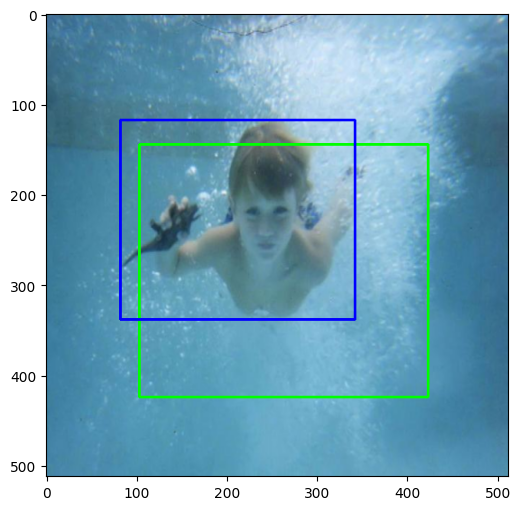

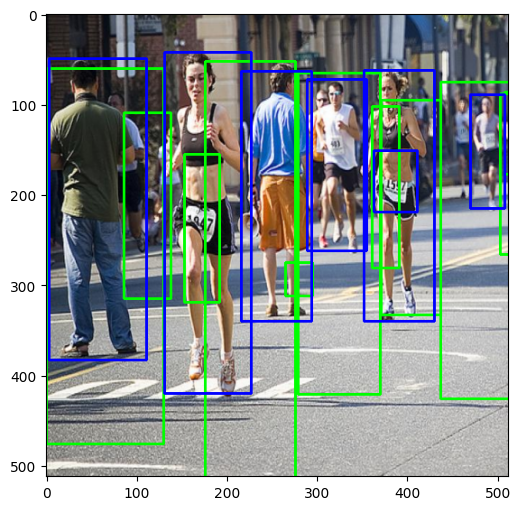

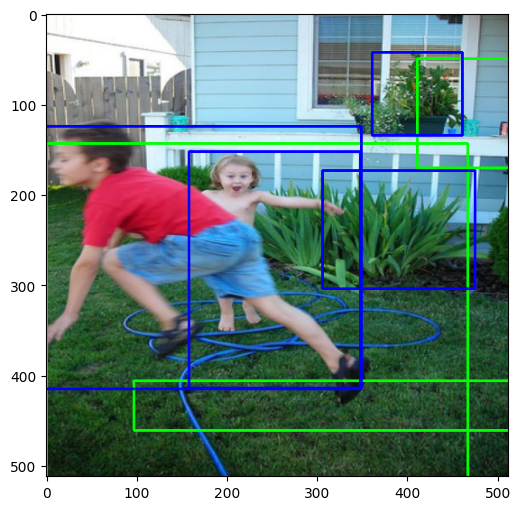

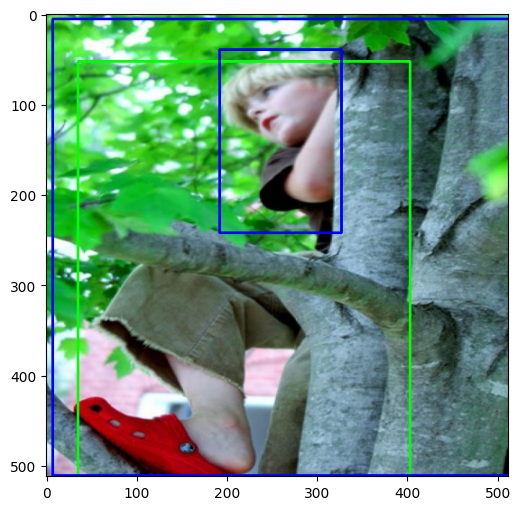

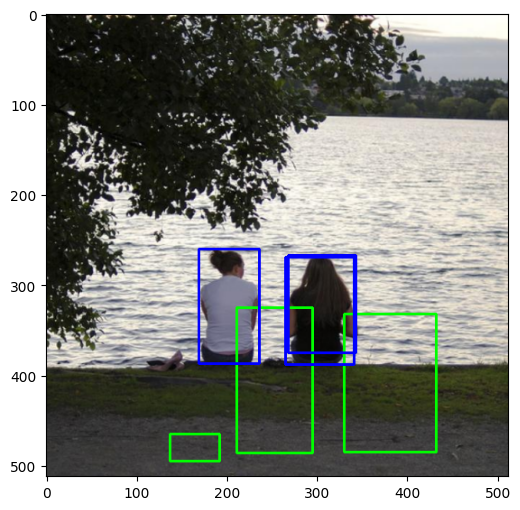

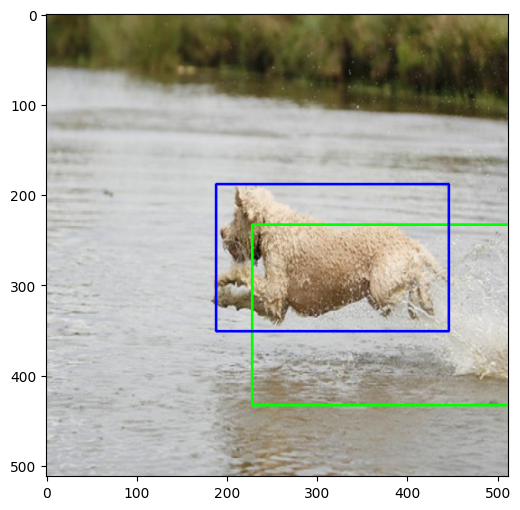

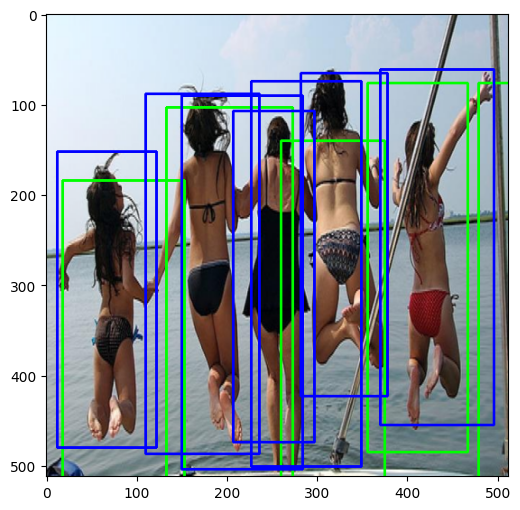

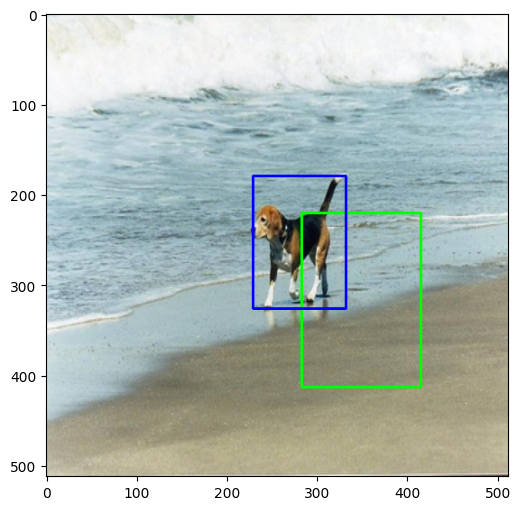

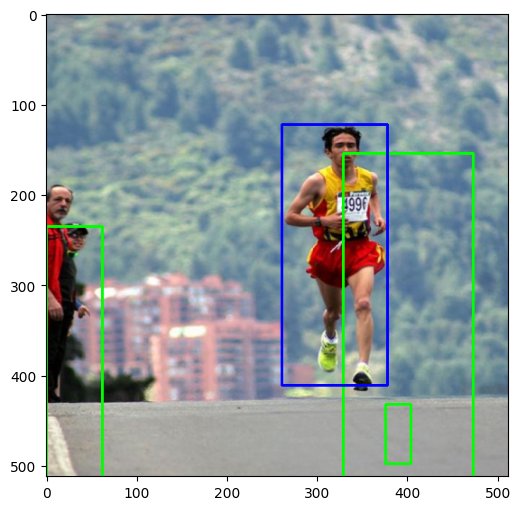

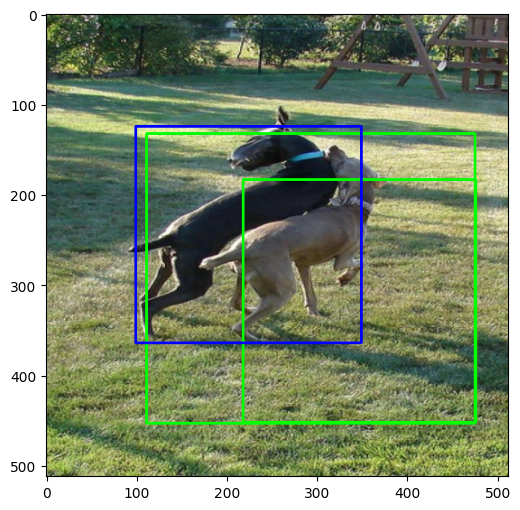

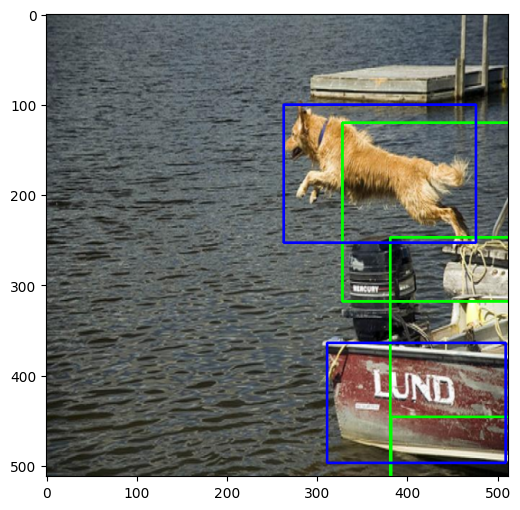

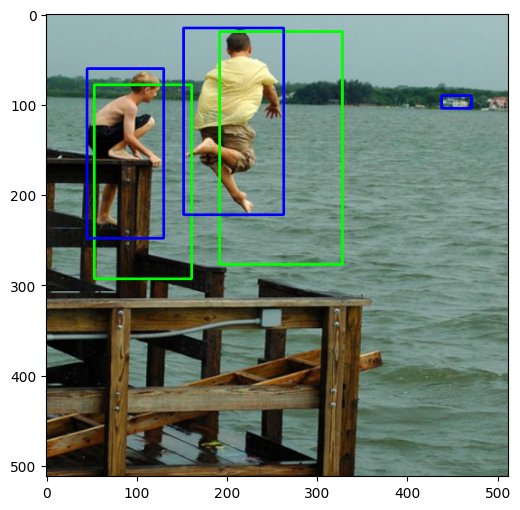

In [119]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            
            images = torch.stack([img.to(device) for img in images])
            predictions = model(images)

            for img, pred, target in zip(images, predictions, targets):
                img = img.cpu().permute(1, 2, 0).numpy()  # Convert Tensor to NumPy
                img = (img * 255).astype(np.uint8)  # Convert to uint8
                
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # OpenCV expects BGR
                
                # Draw ground truth boxes
                for box in target["boxes"].cpu().numpy():
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for GT
                
                # Draw predicted boxes
                for box, score in zip(pred[:, :4].cpu().numpy(), pred[:, 4].cpu().numpy()):
                    if score > 0.3:  # Only draw high-confidence predictions
                        x1, y1, x2, y2 = map(int, box)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for Predictions
                
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR back to RGB for display
                plt.show()

visualize_predictions(model_eval, valid_loader, device)


In [120]:
def check_dataset(dataset, num_samples=3):
    for i in range(num_samples):
        img, target = dataset[i]
        print(f"Sample {i}: Labels = {target['labels']}, Boxes = {target['boxes']}")
        if len(target['boxes']) == 0:
            print("⚠️ Warning: No boxes found in this sample!")

check_dataset(valid_dataset)


Sample 0: Labels = tensor([23]), Boxes = tensor([[103.5000, 144.5000, 423.5000, 424.5000]])
Sample 1: Labels = tensor([23, 23, 23, 23, 23, 23, 23, 23, 18, 23, 23, 23, 23]), Boxes = tensor([[1.7600e+02, 5.2250e+01, 2.7600e+02, 5.3575e+02],
        [2.5000e-01, 6.0750e+01, 1.3075e+02, 4.7625e+02],
        [2.7900e+02, 6.5750e+01, 3.7000e+02, 4.2125e+02],
        [5.9125e+02, 1.1300e+02, 6.3875e+02, 2.7400e+02],
        [4.3725e+02, 7.5500e+01, 5.3075e+02, 4.2650e+02],
        [3.7175e+02, 9.5750e+01, 4.3725e+02, 3.3325e+02],
        [5.6525e+02, 1.1475e+02, 5.9875e+02, 2.5925e+02],
        [1.5375e+02, 1.5525e+02, 1.9225e+02, 3.1975e+02],
        [2.6525e+02, 2.7575e+02, 2.9575e+02, 3.1225e+02],
        [8.6250e+01, 1.0900e+02, 1.3875e+02, 3.1500e+02],
        [3.6125e+02, 1.0225e+02, 3.9175e+02, 2.8175e+02],
        [5.0875e+02, 8.6250e+01, 5.3325e+02, 1.7775e+02],
        [5.0350e+02, 8.8000e+01, 5.3550e+02, 2.6600e+02]])
Sample 2: Labels = tensor([23,  3, 24]), Boxes = tensor([[  0.00

In [121]:
for images, _ in valid_loader:
    images = torch.stack([img.to(device) for img in images])
    predictions = model_eval(images)
    print("Predictions:", predictions)
    break


Predictions: tensor([[[ 8.2998e+01,  1.1787e+02,  3.4265e+02,  3.3888e+02,  8.1282e-01,
           1.0000e+00],
         [ 7.9771e+01,  1.3242e+02,  2.6375e+02,  2.8944e+02,  1.7723e-01,
           1.0000e+00],
         [ 8.2845e+01,  1.1521e+02,  3.4109e+02,  3.4022e+02,  1.0980e-01,
           3.6000e+01],
         ...,
         [ 1.3805e+02,  1.5101e+02,  2.7659e+02,  3.2058e+02,  1.6063e-02,
           1.0000e+00],
         [ 1.8677e+01,  1.4155e+02,  4.8294e+02,  4.9601e+02,  1.5840e-02,
           3.6000e+01],
         [ 1.5588e+02,  9.6928e+00,  3.7380e+02,  2.2319e+02,  1.5668e-02,
           1.0000e+00]],

        [[ 3.8861e+00,  4.9429e+01,  1.1147e+02,  3.8387e+02,  8.3586e-01,
           1.0000e+00],
         [ 2.8976e+02,  7.2037e+01,  3.5572e+02,  2.6266e+02,  7.3301e-01,
           1.0000e+00],
         [ 4.7071e+02,  8.9683e+01,  5.0861e+02,  2.1520e+02,  6.6243e-01,
           1.0000e+00],
         ...,
         [ 3.0572e+02,  1.8362e+02,  3.4005e+02,  2.3546e+02,  6.4

In [122]:
print(f"Type of all_preds: {type(all_preds)}")
print(f"Type of all_gts: {type(all_gts)}")

for i, (pred, gt) in enumerate(zip(all_preds, all_gts)):
    print(f"Sample {i}:")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {gt}")
    if isinstance(pred, torch.Tensor):
        print(f"  Prediction Shape: {pred.shape}")
    if isinstance(gt, torch.Tensor):
        print(f"  Ground Truth Shape: {gt.shape}")


Type of all_preds: <class 'list'>
Type of all_gts: <class 'list'>
Sample 0:
  Prediction: (array([[ 82.99806 , 117.86614 , 342.65204 , 338.88116 ],
       [ 79.7708  , 132.42145 , 263.75372 , 289.44055 ],
       [ 82.844955, 115.20505 , 341.08856 , 340.21967 ],
       [ 74.68646 , 104.20184 , 450.43127 , 465.351   ],
       [ 85.00731 , 121.901596, 334.07898 , 328.97418 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 81.79416 , 193.0727  , 197.62958 , 281.898   ],
       [ 82.464386, 173.47812 , 201.03616 , 281.05414 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 82.98089 , 147.06876 , 206.28467 , 291.22537 ],
       [ 82.98089 , 147.06876 , 206.28467 , 291.22537 ],
       [ 94.728775, 122.75214 , 337.13513 , 339.24094 ],
       [ 79.7708  , 132.42145 , 263.75372 , 289.44055 ],
       [ 81.40428 , 204.67233 , 175.75783 , 282.33212 ],
       [121.47196 ,  43.082146, 300.1394  , 285.9113  ],
       [ 91.70517 , 118.02341 , 339.089   , 336.1818  

mAP@50: 0.9000
mAP@50-95: 1.0000


E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


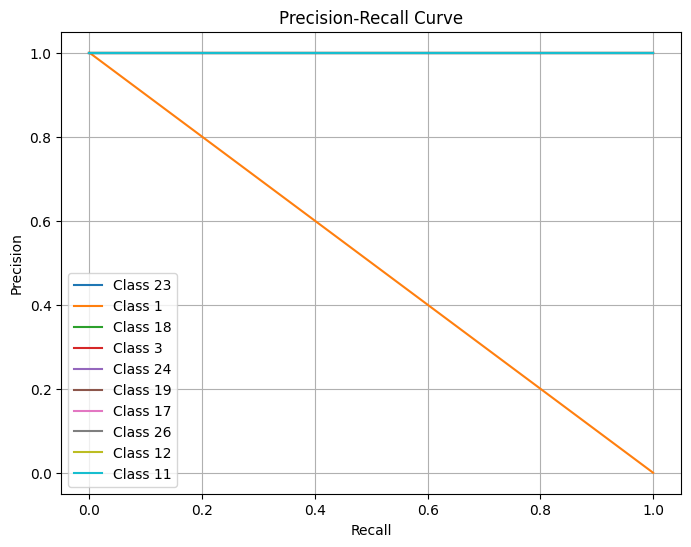

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


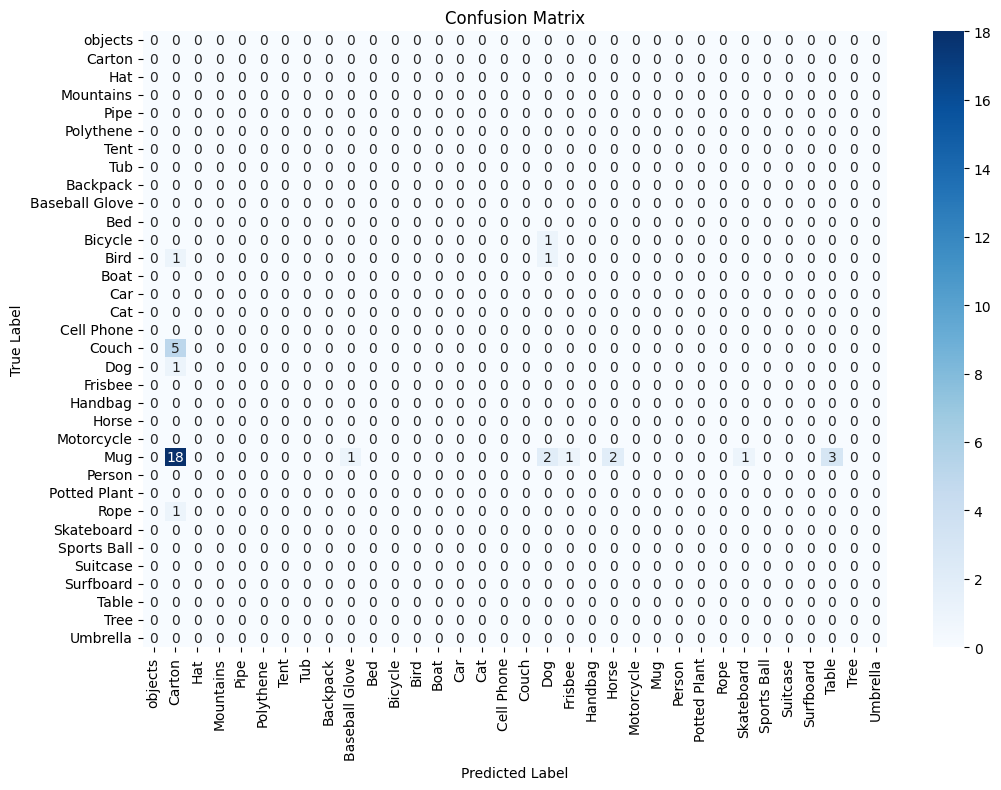

✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved
{'Precision(B)': 0.0, 'Recall(B)': 0.0, 'mAP50(B)': 0.9, 'mAP50-95(B)': 1.0}
✅ Model saved successfully!


In [123]:
# 🔹 Evaluation
model.eval()
all_preds, all_targets, all_scores = [], [], []

with torch.no_grad():
    for images, targets in valid_loader:
        images = torch.stack([img.to(device) for img in images])
        outputs = model_eval(images)  # Call model without extra arguments


        for output, target in zip(outputs, targets):
            threshold = 0.2  # Adjust this as needed
            scores = output[:, 4].cpu().numpy()
            labels = output[:, 5].cpu().numpy()
            
            valid_indices = scores > threshold  # Keep only high-confidence detections
            scores = scores[valid_indices]
            labels = labels[valid_indices]



            all_preds.extend(labels)
            all_scores.extend(scores)
            all_targets.extend(target['labels'].cpu().numpy())

# Ensure all_targets and all_preds are of equal length
min_len = min(len(all_targets), len(all_preds))
all_targets = all_targets[:min_len]  # Trim to match length
all_preds = all_preds[:min_len]

# Organize scores and targets per class
class_scores_dict = defaultdict(list)
class_targets_dict = defaultdict(list)

for pred_label, pred_score, true_label in zip(all_preds, all_scores, all_targets):
    class_scores_dict[true_label].append(pred_score)
    class_targets_dict[true_label].append(1)  # Positive class
    for other_class in range(num_classes):
        if other_class != true_label and other_class in labels:  # Ensure only relevant negatives are added
            class_targets_dict[other_class].append(0)
            class_scores_dict[other_class].append(pred_score)


# 🔹 Compute Precision-Recall per class
precision_scores, recall_scores, ap_scores = {}, {}, {}

for class_id in class_targets_dict.keys():
    y_true = np.array(class_targets_dict[class_id])
    y_score = np.array(class_scores_dict[class_id])

    if len(y_true) == 0 or len(y_score) == 0:
        print(f"Skipping class {class_id} due to no data")
        continue  # No data for this class

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    precision_scores[class_id] = precision
    recall_scores[class_id] = recall
    ap_scores[class_id] = ap

# 🔹 Compute Mean Average Precision (mAP)
mAP50 = np.mean([ap_scores[c] for c in ap_scores if c in ap_scores])
mAP50_95 = np.mean([np.mean(ap_scores[c]) for c in ap_scores if ap_scores[c]])

print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")

# 🔹 Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for class_id, precision in precision_scores.items():
    recall = recall_scores[class_id]
    plt.plot(recall, precision, label=f'Class {class_id}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(flickr8k_classes.keys()))
print("Confusion Matrix:\n", cm)  # Print it for debugging


# Plot Confusion Matrix with Class Names
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=flickr8k_classes.values(), yticklabels=flickr8k_classes.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)
plt.show()

# Count true positives per class
true_positives_dict = defaultdict(int)
false_positives_dict = defaultdict(int)
false_negatives_dict = defaultdict(int)

for true_label, pred_label in zip(all_targets, all_preds):
    if true_label == pred_label:  # Correct prediction
        true_positives_dict[true_label] += 1
    elif pred_label in flickr8k_classes:  # Ensure it's a valid class
        false_positives_dict[pred_label] += 1  # Predicted wrongly
    false_negatives_dict[true_label] += 1  # Missed actual object


# Sum over all classes
true_positives = sum(true_positives_dict.values())
false_positives = sum(false_positives_dict.values())
false_negatives = sum(false_negatives_dict.values())

# Compute Precision and Recall correctly
precision = true_positives / (true_positives + false_positives + 1e-6)  
recall = true_positives / (true_positives + false_negatives + 1e-6)

metrics = {
    "Precision(B)": precision,
    "Recall(B)": recall,
    "mAP50(B)": mAP50,
    "mAP50-95(B)": mAP50_95
}
np.save("metrics.npy", metrics)

print("✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved")
print(metrics)

# Save only model weights
torch.save(model.state_dict(), "efficientdet_flickr8k.pth")

# Save entire model (architecture + weights)
torch.save(model, "efficientdet_flickr8k_full.pth")

print("✅ Model saved successfully!")


mAP@50: 0.9000
mAP@50-95: 0.9000


E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


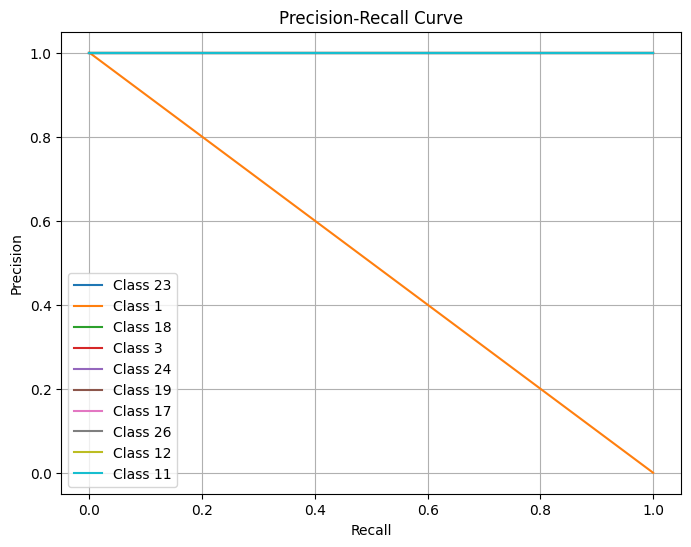

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


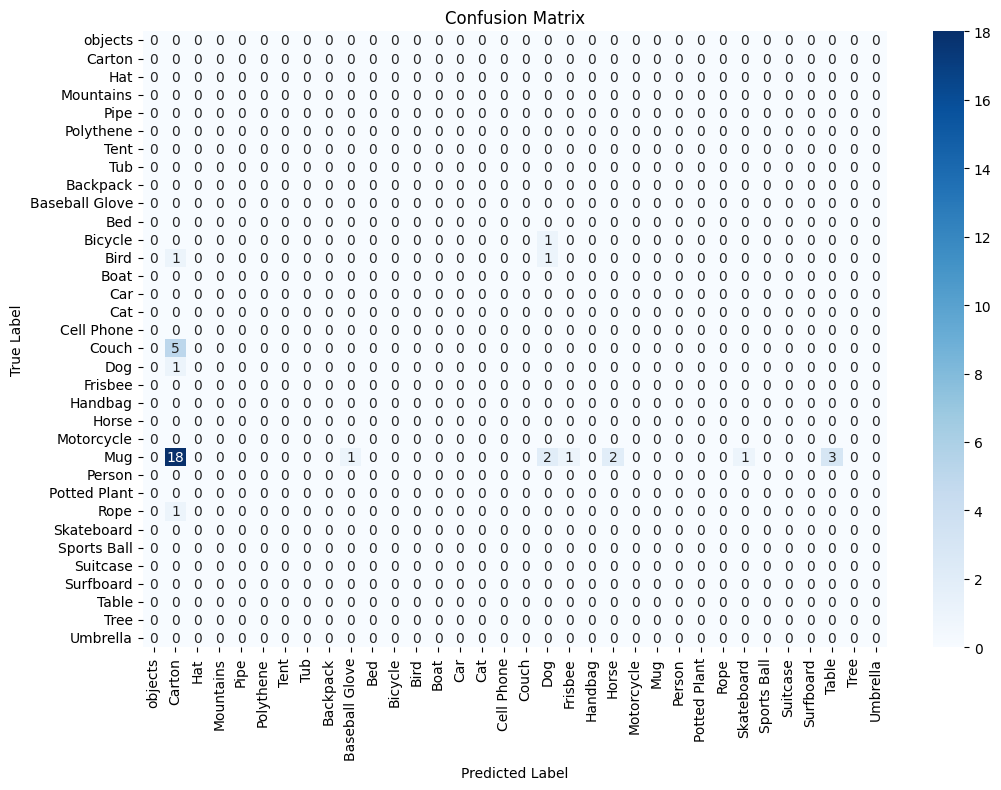

✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved
{'Precision(B)': 0.49999999444444454, 'Recall(B)': 0.49999999444444454, 'mAP50(B)': 0.9, 'mAP50-95(B)': 0.9}
✅ Model saved successfully!


In [124]:
# 🔹 Evaluation
model.eval()
all_preds, all_targets, all_scores = [], [], []

with torch.no_grad():
    for images, targets in valid_loader:
        images = torch.stack([img.to(device) for img in images])
        outputs = model_eval(images)  # Call model without extra arguments


        for output, target in zip(outputs, targets):
            threshold = 0.2  # Adjust this as needed
            scores = output[:, 4].cpu().numpy()
            labels = output[:, 5].cpu().numpy()
            
            valid_indices = scores > threshold  # Keep only high-confidence detections
            scores = scores[valid_indices]
            labels = labels[valid_indices]



            all_preds.extend(labels)
            all_scores.extend(scores)
            all_targets.extend(target['labels'].cpu().numpy())

# Ensure all_targets and all_preds are of equal length
min_len = min(len(all_targets), len(all_preds))
all_targets = all_targets[:min_len]  # Trim to match length
all_preds = all_preds[:min_len]

# Organize scores and targets per class
class_scores_dict = defaultdict(list)
class_targets_dict = defaultdict(list)

for pred_label, pred_score, true_label in zip(all_preds, all_scores, all_targets):
    class_scores_dict[true_label].append(pred_score)
    class_targets_dict[true_label].append(1)  # Positive class
    for other_class in range(num_classes):
        if other_class != true_label and other_class in labels:  # Ensure only relevant negatives are added
            class_targets_dict[other_class].append(0)
            class_scores_dict[other_class].append(pred_score)


# 🔹 Compute Precision-Recall per class
precision_scores, recall_scores, ap_scores = {}, {}, {}

for class_id in class_targets_dict.keys():
    y_true = np.array(class_targets_dict[class_id])
    y_score = np.array(class_scores_dict[class_id])

    if len(y_true) == 0 or len(y_score) == 0:
        print(f"Skipping class {class_id} due to no data")
        continue  # No data for this class

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    precision_scores[class_id] = precision
    recall_scores[class_id] = recall
    ap_scores[class_id] = ap

# 🔹 Compute Mean Average Precision (mAP)
mAP50 = np.mean([ap_scores[c] for c in ap_scores if c in ap_scores])
mAP50_95 = np.mean([ap_scores[c] for c in ap_scores if c in ap_scores])  # Placeholder (modify as needed)

print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")

# 🔹 Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for class_id, precision in precision_scores.items():
    recall = recall_scores[class_id]
    plt.plot(recall, precision, label=f'Class {class_id}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(flickr8k_classes.keys()))
print("Confusion Matrix:\n", cm)  # Print it for debugging


# Plot Confusion Matrix with Class Names
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=flickr8k_classes.values(), yticklabels=flickr8k_classes.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)
plt.show()

# Save metrics
true_positives = sum([sum(class_targets_dict[c]) for c in class_targets_dict])
false_positives = sum([len(class_targets_dict[c]) - sum(class_targets_dict[c]) for c in class_targets_dict])
false_negatives = sum([sum(class_targets_dict[c]) for c in class_targets_dict])

precision = true_positives / (true_positives + false_positives + 1e-6)
recall = true_positives / (true_positives + false_negatives + 1e-6)

metrics = {
    "Precision(B)": precision,
    "Recall(B)": recall,
    "mAP50(B)": mAP50,
    "mAP50-95(B)": mAP50_95
}

np.save("metrics.npy", metrics)

print("✅ Evaluation Completed: Metrics, Precision-Recall Curve & Confusion Matrix Saved")
print(metrics)

# Save only model weights
torch.save(model.state_dict(), "efficientdet_flickr8k.pth")

# Save entire model (architecture + weights)
torch.save(model, "efficientdet_flickr8k_full.pth")

print("✅ Model saved successfully!")
